In [1]:
'''current progress:

I can calculate the Q1+ (B1+) for everything and store it.

update, can do all Q1,2,3 now !!!

todo: P1-3, C3,D3,E3,F123, X


write program to expand dataframe so it can be used in machine learning
'''


'current progress:\n\nI can calculate the Q1+ (B1+) for everything and store it.\n\nupdate, can do all Q1,2,3 now !!!\n\ntodo: P1-3, C3,D3,E3,F123, X\n\n\nwrite program to expand dataframe so it can be used in machine learning\n'

In [2]:
"""
All necessary imports
"""

import math
import csv

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.spatial.distance as distance
import scipy

from pandas import read_csv
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from minepy import MINE

import matplotlib.pyplot as plt
import seaborn
from mrmr import mrmr_classif
import pprint
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import r2_score

from sklearn.feature_selection import SelectFromModel

from mendeleev import element
from mendeleev.fetch import fetch_table
import pandas as pd
import time
import ast
import re

In [13]:
converters = {
    'elem_in_site_order': ast.literal_eval,
    'elem_by_formula_order': ast.literal_eval,
    'num_electrons': ast.literal_eval,
    'eaffinity': ast.literal_eval,
    'dipole': ast.literal_eval,
    'covalent_rad': ast.literal_eval,
    'atomic_vol': ast.literal_eval,
    'atomic_rad': ast.literal_eval,
    'A1': ast.literal_eval,  # Converter for column 'A1'
    'A2': ast.literal_eval,  # Converter for column 'A2'
    'B1': ast.literal_eval,  # Converter for column 'B1'
    'B2': ast.literal_eval,  # Converter for column 'B2'
    'X': ast.literal_eval,   # Converter for column 'X'
}



df2 = pd.read_csv('base_descriptors_parsed.csv', converters=converters)
#display(df2.head(5))

In [14]:
pd.set_option('display.max_columns', None)
df = df2
#display(df.head(1))

#print(df['A1'])
print(type(df.head(1)['A1']))
print(df.head(1)['A1'][0]['atomic_rad'])

#remove 21 faulty materials
df = df[df['X'] != {}]
#display(df.iloc[55:66])



<class 'pandas.core.series.Series'>
130.0


In [15]:
properties = ['atomic_rad', 'atomic_vol','dipole', 'eaffinity','covalent_rad', 'num_electrons']
maxes = {}
#find maximum of each property

for i in properties:
    curmaxabs = 0
    for(index, row) in df.iterrows():  
        for j in row[i]:
            if(abs(j)>curmaxabs):
                curmaxabs=abs(j)
    maxes[i] = curmaxabs
print(maxes)    

norm_factor = 5 #this will be the largest absolute value possible for any value
for i in maxes:
    maxes[i]/=5
print("maxes after dividing by norm factor of ", norm_factor, ": ", maxes)
#normalize the data stored in property order
for i in properties:
    for(index, row) in df.iterrows(): 
        curnew = [] 
        for j in row[i]:
            j/= maxes[i]
            curnew.append(j)

        df.at[index, i] = curnew
#display(df)

#normalize the data stored in site order
sites = ['A1', 'A2', 'B1', 'B2', 'X']
for i in sites:
    for(index, row) in df.iterrows(): 
        curnew = {} 
        for j in row[i]:
            curnew[j] = row[i][j]/maxes[j]
        #display(curnew)
        df.at[index, i] = curnew
display(df)
       

{'atomic_rad': 178.0, 'atomic_vol': 20.5, 'dipole': 153.0, 'eaffinity': 2.30863, 'covalent_rad': 163.0, 'num_electrons': 82}
maxes after dividing by norm factor of  5 :  {'atomic_rad': 35.6, 'atomic_vol': 4.1, 'dipole': 30.6, 'eaffinity': 0.46172599999999997, 'covalent_rad': 32.6, 'num_electrons': 16.4}


,Unnamed: 0,formation_energy,elem_frac,elem_list,energy,formula,magnetic_moment,spin_index,num_p,num_d,num_f,atomic_rad,atomic_vol,covalent_rad,dipole,eaffinity,num_electrons,Unnamed: 17,elem_in_site_order,elem_by_formula_order,A1,A2,B1,B2,X
0,0,-1.152920,"[{Element Cr: 0.1}, {Element Co: 0.1}, {Elemen...","[Element Cr, Element Co, Element Ge, Element T...",-46.782036,Cr1Co1Ge1Te6P1,2.8160,1,4,9,0,"[3.651685393258427, 3.5112359550561796, 3.8483...","[1.7634146341463417, 1.6341463414634148, 3.317...","[3.742331288343558, 3.404907975460123, 3.71165...","[2.562091503267974, 1.8859477124183006, 1.2885...","[1.442413899152311, 1.4343061902513614, 2.6697...","[1.4634146341463417, 1.6463414634146343, 1.951...",NaN,"[Cr, Co, Ge, P, Te]","[Cr, Co, Ge, Te, P]","{'atomic_rad': 3.651685393258427, 'atomic_vol'...","{'atomic_rad': 3.5112359550561796, 'atomic_vol...","{'atomic_rad': 3.8483146067415728, 'atomic_vol...","{'atomic_rad': 3.595505617977528, 'atomic_vol'...","{'atomic_rad': 4.4943820224719095, 'atomic_vol..."
1,1,-1.325311,"[{Element Cr: 0.1}, {Element Co: 0.1}, {Elemen...","[Element Cr, Element Co, Element Ge, Element Te]",-46.171992,Cr1Co1Ge2Te6,3.1420,1,4,9,0,"[3.651685393258427, 3.5112359550561796, 3.8483...","[1.7634146341463417, 1.6341463414634148, 3.317...","[3.742331288343558, 3.404907975460123, 3.71165...","[2.562091503267974, 1.8859477124183006, 1.2885...","[1.442413899152311, 1.4343061902513614, 2.6697...","[1.4634146341463417, 1.6463414634146343, 1.951...",NaN,"[Cr, Co, Ge, Ge, Te]","[Cr, Co, Ge, Te]","{'atomic_rad': 3.651685393258427, 'atomic_vol'...","{'atomic_rad': 3.5112359550561796, 'atomic_vol...","{'atomic_rad': 3.8483146067415728, 'atomic_vol...","{'atomic_rad': 3.8483146067415728, 'atomic_vol...","{'atomic_rad': 4.4943820224719095, 'atomic_vol..."
2,2,-1.458288,"[{Element Cr: 0.1}, {Element Co: 0.1}, {Elemen...","[Element Cr, Element Co, Element Si, Element G...",-47.107590,Cr1Co1Si1Ge1Te6,3.1490,1,4,9,0,"[3.651685393258427, 3.5112359550561796, 3.7078...","[1.7634146341463417, 1.6341463414634148, 2.951...","[3.742331288343558, 3.404907975460123, 3.55828...","[2.562091503267974, 1.8859477124183006, 1.2192...","[1.442413899152311, 1.4343061902513614, 3.0094...","[1.4634146341463417, 1.6463414634146343, 0.853...",NaN,"[Cr, Co, Si, Ge, Te]","[Cr, Co, Si, Ge, Te]","{'atomic_rad': 3.651685393258427, 'atomic_vol'...","{'atomic_rad': 3.5112359550561796, 'atomic_vol...","{'atomic_rad': 3.7078651685393256, 'atomic_vol...","{'atomic_rad': 3.8483146067415728, 'atomic_vol...","{'atomic_rad': 4.4943820224719095, 'atomic_vol..."
3,3,-1.389637,"[{Element Cr: 0.1}, {Element Co: 0.1}, {Elemen...","[Element Cr, Element Co, Element Si, Element T...",-47.821374,Cr1Co1Si1Te6P1,2.8410,0,4,9,0,"[3.651685393258427, 3.5112359550561796, 3.7078...","[1.7634146341463417, 1.6341463414634148, 2.951...","[3.742331288343558, 3.404907975460123, 3.55828...","[2.562091503267974, 1.8859477124183006, 1.2192...","[1.442413899152311, 1.4343061902513614, 3.0094...","[1.4634146341463417, 1.6463414634146343, 0.853...",NaN,"[Cr, Co, Si, P, Te]","[Cr, Co, Si, Te, P]","{'atomic_rad': 3.651685393258427, 'atomic_vol'...","{'atomic_rad': 3.5112359550561796, 'atomic_vol...","{'atomic_rad': 3.7078651685393256, 'atomic_vol...","{'atomic_rad': 3.595505617977528, 'atomic_vol'...","{'atomic_rad': 4.4943820224719095, 'atomic_vol..."
4,4,-1.620268,"[{Element Cr: 0.1}, {Element Co: 0.1}, {Elemen...","[Element Cr, Element Co, Element Si, Element Te]",-48.072190,Cr1Co1Si2Te6,3.1560,1,4,9,0,"[3.651685393258427, 3.5112359550561796, 3.7078...","[1.7634146341463417, 1.6341463414634148, 2.951...","[3.742331288343558, 3.404907975460123, 3.55828...","[2.562091503267974, 1.8859477124183006, 1.2192...","[1.442413899152311, 1.4343061902513614, 3.0094...","[1.4634146341463417, 1.6463414634146343, 0.853...",NaN,"[Cr, Co, Si, Si, Te]","[Cr, Co, Si, Te]","{'atomic_rad': 3.651685393258427, 'atomic_vol'...","{'atomic_rad': 3.5112359550561796, 'atomic_vol...","{'atomic_rad': 3.70786516

In [68]:
'''for each element in elem site order:
    find the index in elem by formula order
    use this index to scrape each atom_rad till num electrons, then add them to a dict in that site

    for me: A1 (aka P1) will be atom radius, atom volume,
            A2 will be dipole polarizability, electron affinity
            A3 will be  covalent radius, num electrons

            
            
in order to read as floats and ints, I will store the method of finding the value as the label of the column

starting out will stick to A-A, A-X, B-X interactions

here are the calculations to see how many columns will be generated
NOTE: IDs from the paper are ABCDEF, since this will be confusing with A and B sites, I will call A and B ids P and Q now:
I am doing 2.5 times the calculations i think
P1:  Atom radius and Atom volume:
P2:  Dipole Polarizability, Electron affinity
P3:  covalent radius, num electrons

the paper is 4,4,6, so I have more features to start with. to prevent this from beign too large an issue I will start by only combining the following:


NOTE: the combinations in the paper are all combinations of two different sites (no A A or B B), with two different symbols to connect them (+ or -).
there are overlaps that are not included (A+B = B+A). this is how they are generated, it took an embarrasing amount of time to verify that

here are the interactions I will consider:

f(A1, A2), f(A2,A1) f(A1,X) f(A2,X) f(X,A1) f(X,A2) f(B1,X) f(B2,X) f(X,B1) f(X,B2)
there are + and - for all of them, which makes the total number for Q1 20, -5 for a1+a2=a2+a1 = 15 This is slightly higher than the 12 from the paper, but manageable

as an example, one of the Q1 descriptors is something like this:
ar = atom radius, av = atom volume

|ar(A1)+ar(A2)|



Q1: absolute differences and sums of P1 : 


this must be very modular, since I am creating order 10,000 columns. 

plan of action:
make list of the 10 interactions that I can loop through (f(A1, A2), f(A2,A1) f(A1,X) f(A2,X) f(X,A1) f(X,A2) f(B1,X) f(B2,X) f(X,B1) f(X,B2))

create a function that takes the two site names as arguments, finds their 2 interactions, and appends them to the respective columns (must compute column name)

calculate(A1, A2, abs_sumdiff, dataframe)

data stored like so:
column name = "P2+", "P2-"

inside column store dict of key value, where key is "ipA1" or "ipA1-ipA2"




'''

'for each element in elem site order:\n    find the index in elem by formula order\n    use this index to scrape each atom_rad till num electrons, then add them to a dict in that site\n\n    for me: A1 (aka P1) will be atom radius, atom volume,\n            A2 will be dipole polarizability, electron affinity\n            A3 will be  covalent radius, num electrons\n\n            \n            \nin order to read as floats and ints, I will store the method of finding the value as the label of the column\n\nstarting out will stick to A-A, A-X, B-X interactions\n\nhere are the calculations to see how many columns will be generated\nNOTE: IDs from the paper are ABCDEF, since this will be confusing with A and B sites, I will call A and B ids P and Q now:\nI am doing 2.5 times the calculations i think\nP1:  Atom radius and Atom volume:\nP2:  Dipole Polarizability, Electron affinity\nP3:  covalent radius, num electrons\n\nthe paper is 4,4,6, so I have more features to start with. to prevent thi

In [16]:
dsct = {
    'P1': ['atomic_rad', 'atomic_vol',],
    'P2': ['dipole', 'eaffinity'],
    'P3': ['covalent_rad', 'num_electrons'],
    'P3&Q3': [['covalent_rad', 'num_electrons'], 'Q3+'],
}
def get_descripts(id):
    return(dsct[id])

In [17]:
def gen_single(pair, sign, row, descripts, i, j): 
    # i is which function to operate on pair[0]
    # j is which function (ie, EA vs IP) to operate on pair[1]
    if sign == '+':
        str1 = descripts[i] + pair[0] + "+" +descripts[j] + pair[1]# 0 0
        val1 = row[pair[0]][descripts[i]] + row[pair[1]][descripts[j]]
        return (str1, val1)
    elif sign == '-':
        str1 = descripts[i] + pair[0] + "-" +descripts[j] + pair[1]# 0 0
        val1 = abs(row[pair[0]][descripts[i]] - row[pair[1]][descripts[j]])
        return (str1, val1)

#aA + aB, aA + bB, bA + aB, bA + bB
# ipA + eaA
# ipB + eaB
def add_to_dict(dct, pair, sign, row, descripts):
    for i in range(2):
        for j in range(2):
            strn, valn = gen_single(pair, sign, row, descripts, i, j)
            dct[strn] = valn
    for i in range(2):
        strn, valn = gen_single((pair[i], pair[i]), sign, row, descripts, 0, 1)
        dct[strn] = valn
        
def add_to_dict_square(dct, row, descripts):
    Q3col = descripts[1]
    for i in row[Q3col]:
        strn = "(" + i + ")"+ "**2"
        valn = row[Q3col][i] ** 2
        dct[strn] = valn
    P3des = descripts[0]
    # for i in P3des:
    #     for j in ['A1', 'A2', 'B1', 'B2', 'X']:
    #         strn = "(" + row[j][i] + ")"+ "**2"
    #     add the square to dict


  #JUST SET UP P1P2P3 FOR THE LOVE OF CHRIST

def add_to_dict_Ps(dct, row, descripts):
    for i in descripts:
        for j in ['A1', 'A2', 'B1', 'B2', 'X']:
            strn = i + j 
            valn = row[j][i]
            dct[strn] = valn

#calculate(A1, A2, abs_sumdiff, dataframe)
def calculate(pairlist, id, sign, row):
    descripts = get_descripts(id)
    dct = {}
   
    if sign == '+' or sign== '-':
        for i in pairlist:
            add_to_dict(dct, i, sign, row, descripts)
    elif sign == '**2':
        add_to_dict_square(dct, row, descripts)
    elif sign == '.':
        add_to_dict_Ps(dct, row, descripts)
    return dct
    

In [18]:
#add and sub is both same amount of calculations
#['P1','P1', '.'],['P2','P2', '.'],['P3','P3', '.'],
cols_to_add = [['P1','P1', '.'],['P2','P2', '.'],['P3','P3', '.'],['Q1+','P1', '+'], ['Q1-','P1', '-'], ['Q2+','P2', '+'],['Q2-','P2', '-'],['Q3+','P3', '+'],['Q3-','P3', '-'],['C3', 'P3&Q3', '**2']]#, ['F1', ['Q1+', 'Q1-'], '++']] # name, type, sign

pairs = [('A1', 'A2'),('A1', 'X'),('A2', 'X'),('B1', 'X'),('B2', 'X')]

#pairs_sub = [('A1', 'A2'),('A1', 'X'),('A2', 'X'),('B1', 'X'),('B2', 'X'), ('A2', 'A1'), ('X', 'A1'), ('X', 'A2'), ('X', 'B1'), ('X', 'B2')]
for p in cols_to_add:
    df[p[0]] = [{} for _ in range(len(df))]

for c in cols_to_add:
    for(index, row) in df.iterrows():    
        tmp = calculate(pairs, c[1], c[2], row)
        df.at[index, c[0]] = tmp
        #print(c[0])

display(df.head(1))
#display(df.iloc[5]['Q1-'])



,Unnamed: 0,formation_energy,elem_frac,elem_list,energy,formula,magnetic_moment,spin_index,num_p,num_d,num_f,atomic_rad,atomic_vol,covalent_rad,dipole,eaffinity,num_electrons,Unnamed: 17,elem_in_site_order,elem_by_formula_order,A1,A2,B1,B2,X,P1,P2,P3,Q1+,Q1-,Q2+,Q2-,Q3+,Q3-,C3
0,0,-1.15292,"[{Element Cr: 0.1}, {Element Co: 0.1}, {Elemen...","[Element Cr, Element Co, Element Ge, Element T...",-46.782036,Cr1Co1Ge1Te6P1,2.816,1,4,9,0,"[3.651685393258427, 3.5112359550561796, 3.8483...","[1.7634146341463417, 1.6341463414634148, 3.317...","[3.742331288343558, 3.404907975460123, 3.71165...","[2.562091503267974, 1.8859477124183006, 1.2885...","[1.442413899152311, 1.4343061902513614, 2.6697...","[1.4634146341463417, 1.6463414634146343, 1.951...",NaN,"[Cr, Co, Ge, P, Te]","[Cr, Co, Ge, Te, P]","{'atomic_rad': 3.651685393258427, 'atomic_vol'...","{'atomic_rad': 3.5112359550561796, 'atomic_vol...","{'atomic_rad': 3.8483146067415728, 'atomic_vol...","{'atomic_rad': 3.595505617977528, 'atomic_vol'...","{'atomic_rad': 4.4943820224719095, 'atomic_vol...","{'atomic_radA1': 3.651685393258427, 'atomic_ra...","{'dipoleA1': 2.562091503267974, 'dipoleA2': 1....","{'covalent_radA1': 3.742331288343558, 'covalen...",{'atomic_radA1+atomic_radA2': 7.16292134831460...,{'atomic_radA1-atomic_radA2': 0.14044943820224...,"{'dipoleA1+dipoleA2': 4.448039215686275, 'dipo...","{'dipoleA1-dipoleA2': 0.6761437908496735, 'dip...",{'covalent_radA1+covalent_radA2': 7.1472392638...,{'covalent_radA1-covalent_radA2': 0.3374233128...,{'(covalent_radA1+covalent_radA2)**2': 51.0830...


In [19]:
#expand dataframe into model friendly format
to_expand = ['P1', 'P2', 'P3', 'Q1+', 'Q1-', 'Q2+', 'Q2-', 'Q3+', 'Q3-', 'C3']
df4 = df
for i in to_expand:
    #print(len(df4[i][5]))
    df4 = df4.drop(columns=i).join(df4[i].apply(pd.Series))
#display(df4.head(4))
#df4.to_csv('mmm.csv', index=False)

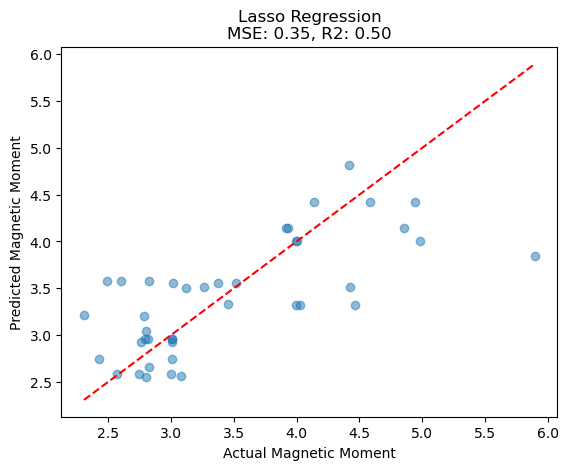

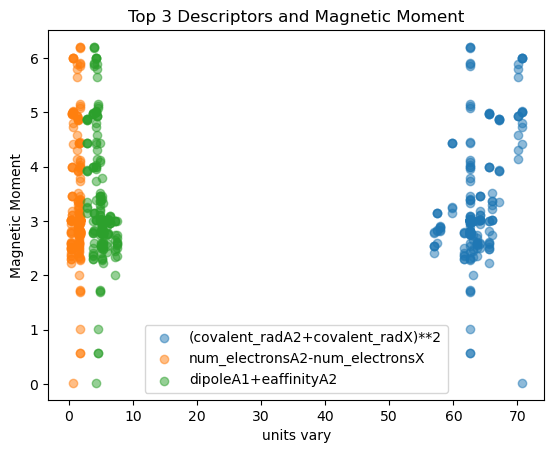

Top 1 Descriptor: (covalent_radA2+covalent_radX)**2, Importance: 0.1615
Top 2 Descriptor: num_electronsA2-num_electronsX, Importance: 0.1675
Top 3 Descriptor: dipoleA1+eaffinityA2, Importance: 0.1928


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Sample data for demonstration
# Replace X and y with your own dataset
# X should be a 2D array where each row represents a data point, and each column represents a feature
# y should be a 1D array representing the target variable
# For example, X = [[feature1_val1, feature2_val1], [feature1_val2, feature2_val2], ...]
# and y = [target_val1, target_val2, ...]
target_column_index = df4.columns.get_loc("atomic_radA1")
X = df4.iloc[:, target_column_index:]
y = df4['magnetic_moment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Lasso Regression model
alpha = 0.1  # Regularization strength (tuning parameter)
lasso_model = Lasso(alpha=alpha)

# Train the model
lasso_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lasso_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Coefficients of the line equation
slope = lasso_model.coef_[0]
intercept = lasso_model.intercept_

# Scatter plot
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Magnetic Moment')
plt.ylabel('Predicted Magnetic Moment')
plt.title(f'Lasso Regression\nMSE: {mse:.2f}, R2: {r2:.2f}')
plt.show()

# Get the absolute feature coefficients from the Lasso model
feature_coefficients = np.abs(lasso_model.coef_)

# Get the indices of the top k features
k = 3
top_k_indices = np.argsort(feature_coefficients)[-k:]

# Select the top k descriptors from the dataset
top_k_descriptors = X.columns[top_k_indices]

# Scatter plot of the top k descriptors and the magnetic moment
for descriptor in top_k_descriptors:
    plt.scatter(df4[descriptor], df4['magnetic_moment'], alpha=0.5, label=descriptor)

plt.xlabel('units vary')
plt.ylabel('Magnetic Moment')
plt.title(f'Top {k} Descriptors and Magnetic Moment')
plt.legend()
plt.show()

# Get the importances of the top k descriptors
top_k_importances = feature_coefficients[top_k_indices]

# Print the importances of the top k descriptors
for i, descriptor in enumerate(top_k_descriptors):
    print(f"Top {i+1} Descriptor: {descriptor}, Importance: {top_k_importances[i]:.4f}")

